In [16]:
import pickle
import os
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
os.chdir(os.path.expanduser('~/wcEcoli/'))
# noinspection PyUnresolvedReferences
from wholecell.io.tablereader import TableReader
import io
import numpy as np
from wholecell.io import tsv
from wholecell.utils.filepath import ROOT_PATH
import plotly.graph_objects as go
from models.ecoli.analysis import cohortAnalysisPlot
from wholecell.analysis.analysis_tools import (exportFigure,
	read_bulk_molecule_counts, read_stacked_bulk_molecules, read_stacked_columns)
from wholecell.io.tablereader import TableReader
from sklearn.metrics import r2_score
import plotly.graph_objects as go
import glob
import plotly.express as px

In [2]:
# function to match gene symbols to monomer ids
def get_gene_symbols_for_monomer_ids():
	"""
	Extracts the gene symbols for each monomer id in the model.
	Returns: a dictionary mapping monomer ids to gene symbols.
	Code adapted from convert_to_flat.py.
	"""
	RNAS_FILE = os.path.join(ROOT_PATH, 'reconstruction', 'ecoli',
								 'flat', 'rnas.tsv')
	with (io.open(RNAS_FILE, 'rb') as f):
		reader = tsv.reader(f, delimiter='\t')
		headers = next(reader)
		while headers[0].startswith('#'):
			headers = next(reader)

		# extract relevant information
		gene_symbol_index = headers.index('common_name')
		protein_id_index = headers.index('monomer_ids')
		monomer_ids_to_gene_symbols = {}
		for line in reader:
			gene_symbol = line[gene_symbol_index]
			protein_id = list(
				line[protein_id_index][2:-2].split('", "'))[0]
			monomer_ids_to_gene_symbols[protein_id] = gene_symbol

	return monomer_ids_to_gene_symbols

def get_common_name(protein_id):
    """
    Get the common name of a protein given its monomer id.
    Args:
        protein_id: the name of the monomer

    Returns:
        common_name: The common name of the protein.

    """
    if '[' in protein_id:
        protein_id = protein_id[:-3]  # subtract the compartment
        
    if protein_id == 'NG-GFP-MONOMER':
        print('NEW GENE PRESENT')
    else:
        common_name = get_gene_symbols_for_monomer_ids()[protein_id]
    return common_name

In [33]:
current_sequence = "CLClim3NE_pd_dynamics_test_Kms2" # y axis (note that CLClim3NE3 is bascially CLNE3
CLNE_sequence = "CLNE3"

In [34]:
# read in the CLNE1 half life data: 
CLNE1_HLs = f"out/{CLNE_sequence}/kb_plot_out/protein_half_lives.tsv"
CLNE1_HLs = pd.read_csv(CLNE1_HLs, sep='\t')
CLNE1_HLs = CLNE1_HLs.rename(columns={"half_life_(min)": "original_half_life"})
CLNE1_HLs = CLNE1_HLs.drop(columns={"degradation_rate(1/s)", "degradation_rate_source"})

# read in the CLClim3NE1 half life data:
CLClim3NE1_HLs = f"out/{current_sequence}/kb_plot_out/protein_half_lives.tsv"
CLClim3NE1_HLs = pd.read_csv(CLClim3NE1_HLs, sep='\t')
CLClim3NE1_HLs = CLClim3NE1_HLs.rename(columns={"half_life_(min)": "new_half_life"})
CLClim3NE1_HLs = CLClim3NE1_HLs.drop(columns={"degradation_rate(1/s)", "degradation_rate_source"})

# merge the two together: 
combined_df = pd.merge(CLClim3NE1_HLs, CLNE1_HLs, on='monomer_id', how='inner')

# add the common names to the dataframe:
combined_df['common_name'] = None
for index, row in combined_df.iterrows():
    common_name = get_common_name(row['monomer_id'])
    combined_df.at[index, 'common_name'] = common_name


CLNE_new_name = "Log10 " +CLNE_sequence +" Average Monomer Counts"
CLClimNE_new_name = "Log10 " +current_sequence +" Average Monomer Counts"

# read in the unfiltered data and remove the last three characters from each entry in the Monomer ID column: 
CLClimNE_log_data = pd.read_csv(
    f'out/{current_sequence}/wildtype_000000/cohort_average_monomer_count_data/unfiltered_data/log_data/LogAvgProteinCounts_startGen_2.csv')
CLClimNE_log_data['Monomer ID'] = CLClimNE_log_data['Monomer ID'].str[:-3]

# do the same for the 2020 model:
CLNE_log_data = pd.read_csv(f'out/{CLNE_sequence}/wildtype_000000/cohort_average_monomer_count_data/unfiltered_data/log_data/LogAvgProteinCounts_startGen_2.csv')
CLNE_log_data['Monomer ID'] = CLNE_log_data['Monomer ID'].str[:-3]

# merge the two dataframes:
CLNE_log_data = CLNE_log_data.rename(columns={"Log10 Average Monomer Counts": CLNE_new_name})
CLClimNE_log_data = CLClimNE_log_data.rename(columns={"Log10 Average Monomer Counts": CLClimNE_new_name})
CLNE_log_data = CLNE_log_data.set_index("Monomer ID")
CLClimNE_log_data = CLClimNE_log_data.set_index("Monomer ID")
CLNE_CLClimNE_log_data = CLNE_log_data.join(CLClimNE_log_data, on="Monomer ID", how="inner")
CLNE_CLClimNE_log_data = CLNE_CLClimNE_log_data.reset_index()
CLNE_CLClimNE_log_data = CLNE_CLClimNE_log_data.rename(columns={"Monomer ID": "monomer_id"})


# merge into combined_df:
combined_df = pd.merge(combined_df, CLNE_CLClimNE_log_data, on='monomer_id', how='inner')


# now add in the validation data... AHHH! 
# read in the unfiltered data and remove the last three characters from each entry in the Monomer ID column: 
CLClimNE_log_validaiton_data = pd.read_csv(
    f'out/{current_sequence}/wildtype_000000/cohort_average_monomer_count_data/validation_data/log_data/Log10_Schmidt_Comparison_startGen_2.csv')
CLClimNE_log_validaiton_data['Monomer ID'] = CLClimNE_log_validaiton_data['Monomer ID'].str[:-3]

combined_df['Log10 Validation Data Average Monomer Counts'] = None
for index, row in combined_df.iterrows():
    monomer_id = row['monomer_id']
    # Check if the monomer_id exists in the validation data
    if monomer_id in CLClimNE_log_validaiton_data['Monomer ID'].values:
        # Get the corresponding value from the validation data
        validation_value = CLClimNE_log_validaiton_data.loc[CLClimNE_log_validaiton_data['Monomer ID'] == monomer_id, 'Log10 Schmidt Validation Counts'].values[0]
        combined_df.at[index, 'Log10 Validation Data Average Monomer Counts'] = validation_value
    else: 
        # If the monomer_id is not found, you can choose to set it to NaN or some other value
        combined_df.at[index, 'Log10 Validation Data Average Monomer Counts'] = None # do I need to do this? is it already happening?


combined_df

,monomer_id,new_half_life,original_half_life,common_name,Log10 CLNE3 Average Monomer Counts,Log10 CLClim3NE_pd_dynamics_test_Kms2 Average Monomer Counts,Log10 Validation Data Average Monomer Counts
0,1-ACYLGLYCEROL-3-P-ACYLTRANSFER-MONOMER,501.707893,600.0,plsC,2.249742,2.239675,1.643453
1,1-PFK-MONOMER,766.256894,600.0,fruK,1.958683,1.747600,1.755875
2,2-DEHYDROPANTOATE-REDUCT-MONOMER,600.000000,600.0,panE,2.166982,2.321794,1.414973
3,2-ISOPROPYLMALATESYN-MONOMER,276.924332,600.0,leuA,3.652449,3.482980,3.43329
4,2-OCTAPRENYL-METHOXY-BENZOQ-METH-MONOMER,493.397050,600.0,ubiE,2.673989,2.695617,2.968483
...,...,...,...,...,...,...,...
4305,YTFR-MONOMER,654.149344,600.0,ytfR,1.282915,1.180822,0.0
4306,YTFT-MONOMER,600.000000,600.0,ytfT,1.298818,1.138950,None
4307,ZNUA-MONOMER,638.129701,600.0,znuA,2.829617,2.872238,2.638489
4308,ZNUB-MONOMER,600.000000,600.0,znuB,1.797419,1.829640,None


In [35]:
proteins_of_interest = ['G6890-MONOMER','PD03938','G6737-MONOMER','RPOD-MONOMER','PD02936','RED-THIOREDOXIN2-MONOMER']

# create interest data frame:
interest_df = combined_df[combined_df['monomer_id'].isin(proteins_of_interest)]
interest_df

,monomer_id,new_half_life,original_half_life,common_name,Log10 CLNE3 Average Monomer Counts,Log10 CLClim3NE_pd_dynamics_test_Kms2 Average Monomer Counts,Log10 Validation Data Average Monomer Counts
2229,G6737-MONOMER,288.738238,600.0,ydcI,2.810495,2.753942,2.127105
2342,G6890-MONOMER,214.018094,600.0,nemA,2.325658,2.438187,2.0
3854,PD02936,468.602732,600.0,fhlA,1.300658,0.168691,None
3863,PD03938,79.151002,600.0,metR,0.191488,0.266758,1.662758
3977,RED-THIOREDOXIN2-MONOMER,367.223275,600.0,trxC,2.840568,2.761663,2.41162
4002,RPOD-MONOMER,503.910765,600.0,rpoD,2.824057,2.768195,2.812245


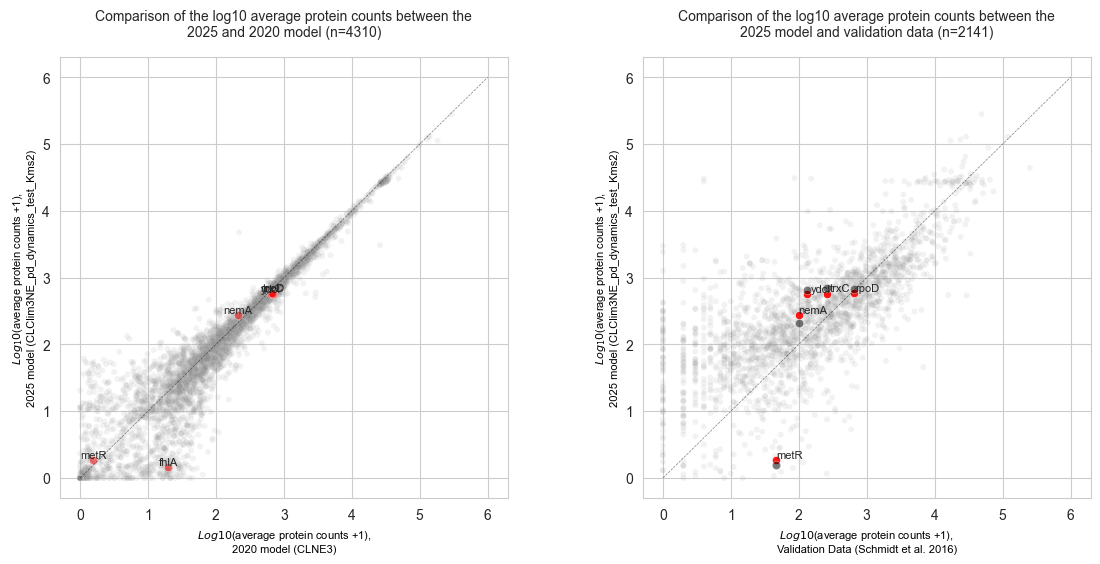

In [36]:
# edit the plot out file as needed
out_pth = f"out/figures/PDR_UPDATE_MERGE/F2/change_in_half_life_histograms/counts_comparison_plot__{proteins_of_interest}__{current_sequence}_{CLNE_sequence}.png"

validaiton_column = 'Log10 Validation Data Average Monomer Counts'

# ok now make a 2 by 2 plot

def make_counts_comparison_with_upper_HL_change_data(row, col, whole_df, interest_df):
    # define the axes:
    ax = axes[row]
    
    # plot all of the proteins 
    sns.scatterplot(data=whole_df, x=whole_df[CLNE_new_name], y=whole_df[CLClimNE_new_name], color='grey', size=0.1, alpha=0.1, ax=ax, )
    
    # plot the proteins of interest:
    sns.scatterplot(data=interest_df, x=interest_df[CLNE_new_name], y=interest_df[CLClimNE_new_name], color='red', alpha=0.5, ax=ax, )
    ax.plot([0, 6], [0, 6], color='black', linestyle='--', linewidth=.5, alpha=0.5)
    
    # plot the common name of the proteins of interest:
    for i, name in enumerate(interest_df['common_name'].unique()):
        # get the index of the protein:
        index = interest_df[interest_df['common_name'] == name].index[0]
        # get the x and y values:
        x = interest_df[CLNE_new_name][index]
        y = interest_df[CLClimNE_new_name][index]
        # plot the common name:
        ax.text(x, y, name, ha='center', va='bottom', fontsize=8, rotation=0, )
    
    # Plot specs:
    ax.set_title(f'Comparison of the log10 average protein counts between the\n2025 and 2020 model (n={whole_df.shape[0]})', fontsize=10, pad=15, )
    ax.set_xlabel(f'$Log10$(average protein counts +1),\n2020 model ({CLNE_sequence})', fontsize=8, color="black", )
    ax.set_ylabel(f'$Log_10$(average protein counts +1),\n2025 model ({current_sequence})', fontsize=8, color="black", )
    
    # add a legend:
    #legend_labels = [f'all proteins (n={whole_df.shape[0]})', f'proteins with the largest +$\\Delta$\n in half life (n={interest_df.shape[0]})']
    #handles, _ = ax.get_legend_handles_labels()
    #ax.legend(handles=handles, labels=legend_labels, loc='upper left', fontsize=8, frameon=False, markerscale=2)
    ax.legend()
    ax.get_legend().set_visible(False)
 
# now make a plot for the validation comparison: 
def make_counts_comparison_with_upper_HL_change_validation_data(row, col, whole_df, interest_df):
    # define the axes:
    ax = axes[row]
    
    # clean up the data: 
    x_col = 'Log10 Validation Data Average Monomer Counts'
    y_col = CLClimNE_new_name
    y_col2 = CLNE_new_name

    # remove proteins that have "None" in their y_col: 
    whole_df_to_plot = whole_df[whole_df[x_col].notna()]
    interest_df_to_plot = interest_df[interest_df[x_col].notna()]

    
    # plot all of the proteins 
    sns.scatterplot(data=whole_df_to_plot, x=whole_df_to_plot[x_col], y=whole_df_to_plot[y_col], color='grey', size=.1, alpha=0.1, ax=ax,)
    
    # plot the proteins of interest:
    sns.scatterplot(data=interest_df_to_plot, x=interest_df_to_plot[x_col], y=interest_df_to_plot[y_col], color='red', alpha=0.9, ax=ax)
    sns.scatterplot(data=interest_df_to_plot, x=interest_df_to_plot[x_col], y=interest_df_to_plot[y_col2], color='black', alpha=0.5, ax=ax)
    
    # add a y=x dotted line:
    ax.plot([0, 6], [0, 6], color='black', linestyle='--', linewidth=.5, alpha=0.5)
    
    # plot the common name of the proteins of interest:
    for i, name in enumerate(interest_df_to_plot['common_name'].unique()):
        # get the index of the protein:
        index = interest_df_to_plot[interest_df_to_plot['common_name'] == name].index[0]
        # get the x and y values:
        x = interest_df_to_plot[x_col][index]
        y = interest_df_to_plot[y_col][index]
        # plot the common name:
        ax.text(x+.2, y, name, ha='center', va='bottom', fontsize=8, rotation=0, )
        
        # also make a line between the two: 
        y2 = interest_df_to_plot[y_col2][index]
        difference = y - y2
        if difference > 0.2:
            dx = x-x
            dy = y - y2
            #ax.arrow([x, x], [y, y2], color='red', linewidth=.5, alpha=0.5)
            ax.arrow(x, y2, dx, dy, color='red', linewidth=.5, alpha=0.5, head_width=0.1, head_length=0.15, length_includes_head=True)
    
    # Plot specs:
    ax.set_title(f'Comparison of the log10 average protein counts between the\n2025 model and validation data (n={whole_df_to_plot.shape[0]})', fontsize=10, pad=15, )
    ax.set_xlabel(f'$Log10$(average protein counts +1),\nValidation Data (Schmidt et al. 2016)', fontsize=8, color="black", )
    ax.set_ylabel(f'$Log_10$(average protein counts +1),\n2025 model ({current_sequence})', fontsize=8, color="black", )
    ax.legend()
    ax.get_legend().set_visible(False)



# MAKE THE PLOT
# using this: https://sharkcoder.com/data-visualization/mpl-bidirectional
font_color = '#525252'
hfont = {'fontname':'Calibri'}
color_red = '#fd625e'
color_blue = '#01b8aa'
fig, axes = plt.subplots(figsize=(11,5),  nrows=1, ncols=2, )
fig.tight_layout()

# plot the plots 
make_counts_comparison_with_upper_HL_change_data(0,0, combined_df, interest_df)
make_counts_comparison_with_upper_HL_change_validation_data(1,1, combined_df, interest_df)

fig.subplots_adjust(wspace=0.3, hspace=0.4)

# save the figure:
out_pth = os.path.expanduser(out_pth)
output_dir = os.path.dirname(out_pth)
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it does not exist
plt.savefig(out_pth, dpi=300, bbox_inches='tight')
